In [1]:
# Import functions and libraries
from __future__ import division
%pylab
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pyaudio
import Queue
import threading,time
import sys
from numpy import *
from scipy import *
import scipy.signal as signal
from rtlsdr import RtlSdr
from numpy.fft import *
from scipy import signal

import serial
%matplotlib inline


Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spect

def sg_plot( t_range, f_range, y, dbf = 60) :
    eps = 1e-3
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( abs( y ) / y_max + eps )
    
    fig=figure(figsize=(15,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Phase')
    plt.tight_layout()
    
def phase_plot(t_range, f_range, y, dbf = 60):
    eps = 1e-3
    
#     # find maximum
#     y_max = abs(y).max()
    
#     # compute 20*log magnitude, scaled to the max
#     y_log = 20.0 * np.log10( abs( y ) / y_max + eps )

    y_phase = np.angle(y)
    
    fig=figure(figsize=(15,6))
    # 64.0*(y_phase + dbf)/dbf 
    plt.imshow( np.flipud(y_phase ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()


def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = append(x,zeros(-lx+nt*m))
    x = x.reshape((m/2,nt*2), order='F')
    x = concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m/2,:],dbf=dbf)
        print 1
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

def myspectrogram_phase_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = append(x,zeros(-lx+nt*m))
    x = x.reshape((m/2,nt*2), order='F')
    x = concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        phase_plot(t_range, f_range, xmf[0:m/2,:],dbf=dbf)
        print 1
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        phase_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf


def play_audio( Q, p, fs , dev, ser="", keydelay=0.200):
    # play_audio plays audio with sampling rate = fs
    # Q - A queue object from which to play
    # p   - pyAudio object
    # fs  - sampling rate
    # dev - device number
    # ser - pyserial device to key the radio
    # keydelay - delay after keying the radio
    
    # Example:
    # fs = 44100
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # Q = Queue.queue()
    # Q.put(data)
    # Q.put("EOT") # when function gets EOT it will quit
    # play_audio( Q, p, fs,1 ) # play audio
    # p.terminate() # terminate pyAudio
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),output=True,output_device_index=dev)
    # play audio
    while (1):
        data = Q.get()
        if data=="EOT"  :
            break
        elif (data=="KEYOFF"  and ser!=""):
            time.sleep(keydelay)
            ser.setDTR(0)
            #print("keyoff\n")
        elif (data=="KEYON" and ser!=""):
            ser.setDTR(1)  # key PTT
            #print("keyon\n")
            time.sleep(keydelay) # wait 200ms (default) to let the power amp to ramp up
            
        else:
            try:
                ostream.write( data.astype(np.float32).tostring() )
            except:
                print("Exception")
                break
            
def record_audio( queue, p, fs ,dev,chunk=1024):
    # record_audio records audio with sampling rate = fs
    # queue - output data queue
    # p     - pyAudio object
    # fs    - sampling rate
    # dev   - device number 
    # chunk - chunks of samples at a time default 1024
    #
    # Example:
    # fs = 44100
    # Q = Queue.queue()
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # record_audio( Q, p, fs, 1) # 
    # p.terminate() # terminate pyAudio
    
   
    istream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),input=True,input_device_index=dev,frames_per_buffer=chunk)

    # record audio in chunks and append to frames
    frames = [];
    while (1):
        try:  # when the pyaudio object is distroyed stops
            data_str = istream.read(chunk) # read a chunk of data
        except:
            break
        data_flt = np.fromstring( data_str, 'float32' ) # convert string to float
        queue.put( data_flt ) # append to list



In [3]:
# Your code here:
def genChirpPulse(Npulse, f0, f1, fs):
    #     Function generates an analytic function of a chirp pulse
    #     Inputs:
    #             Npulse - pulse length in samples
    #             f0     - starting frequency of chirp
    #             f1     - end frequency of chirp
    #             fs     - sampling frequency
    
    # generate time index
    sec_dur = Npulse * (1/fs)
    t = np.arange(0,sec_dur + 1/fs,1/fs)

    # generate f_of_t
    slope = (f1 - f0)/sec_dur
    f_of_t = slope*t + f0

    # generate phi_of_t
    phi_of_t = 2*math.pi*np.cumsum(f_of_t) * (1/fs)

    # generate chirp signal
    s_chirp = (0.5 * np.ones(len(t))) * map(math.sin,phi_of_t) 
    
    return s_chirp

In [4]:
def text2Morse(text,fc,fs,dt):
    CODE = {'A': '.-',     'B': '-...',   'C': '-.-.', 
        'D': '-..',    'E': '.',      'F': '..-.',
        'G': '--.',    'H': '....',   'I': '..',
        'J': '.---',   'K': '-.-',    'L': '.-..',
        'M': '--',     'N': '-.',     'O': '---',
        'P': '.--.',   'Q': '--.-',   'R': '.-.',
     	'S': '...',    'T': '-',      'U': '..-',
        'V': '...-',   'W': '.--',    'X': '-..-',
        'Y': '-.--',   'Z': '--..',
        
        '0': '-----',  '1': '.----',  '2': '..---',
        '3': '...--',  '4': '....-',  '5': '.....',
        '6': '-....',  '7': '--...',  '8': '---..',
        '9': '----.',

        ' ': ' ', "'": '.----.', '(': '-.--.-',  ')': '-.--.-',
        ',': '--..--', '-': '-....-', '.': '.-.-.-',
        '/': '-..-.',   ':': '---...', ';': '-.-.-.',
        '?': '..--..', '_': '..--.-'
        }
    
    Ndot= 1.0*fs*dt
    Ndah = 3*Ndot
    
    sdot = sin(2*pi*fc*r_[0.0:Ndot]/fs)
    sdah = sin(2*pi*fc*r_[0.0:Ndah]/fs)
    
    # convert to dit dah
    mrs = ""
    for char in text:
        mrs = mrs + CODE[char.upper()] + "*"
    
    sig = zeros(1)
    for char in mrs:
        if char == " ":
            sig = concatenate((sig,zeros(Ndot*7)))
        if char == "*":
            sig = concatenate((sig,zeros(Ndot*3)))
        if char == ".":
            sig = concatenate((sig,sdot,zeros(Ndot)))
        if char == "-":
            sig = concatenate((sig,sdah,zeros(Ndot)))
    return sig            

In [5]:
def printDevNumbers(p):
    N = p.get_device_count()
    for n in range(0,N):
        name = p.get_device_info_by_index(n).get('name')
        print n, name

In [6]:
p = pyaudio.PyAudio()
printDevNumbers(p)
p.terminate()

0 Built-in Microph
1 Built-in Output


In [7]:
dusb_in = 2
dusb_out = 2
din = 0
dout = 1

In [8]:
if sys.platform == 'darwin':  # Mac
    s = serial.Serial(port='/dev/tty.SLAB_USBtoUART')
#     s = serial.Serial(port='/dev/cu.SLAB_USBtoUART')
else:                         #windows
    s = serial.Serial(port='COM1') ##### CHANGE !!!!!!
s.setDTR(0)

In [37]:
# ?RtlSdr

In [8]:
#TESTING CHIRP (if constructed correctly)

fs = 44100
t = 5 # chirp length
f0 = 0
f1 = 8000
chirp = genChirpPulse(t * fs, f0, f1, fs)

p = pyaudio.PyAudio()

Qout = Queue.Queue()

# initialize a recording thread.
t_play = threading.Thread(target = play_audio,   args = (Qout,   p, 44100, dout))


# start the recording and playing threads
t_play.start()

Qout.put( chirp );
Qout.put( "EOT" );

while not(Qout.empty()) :
    time.sleep(1)

# terminate pyAudio
p.terminate()

In [10]:
text = 'KK6SSD TESTING'
fs = 44100.0
fc = 850
dt = 0.05
 
sig = text2Morse(text,fc,fs,dt)

# creates a queue
Qout = Queue.Queue()

# create a pyaudio object
p = pyaudio.PyAudio()

t_play = threading.Thread(target = play_audio,   args = (Qout,   p, 44100, dusb_out, s, 0.3 ))

# play audio from Queue 
t_play.start()

Qout.put("KEYON")
Qout.put(sig)
Qout.put("KEYOFF")
Qout.put("EOT")

# must wait for the queue to empty before terminating pyaudio
while not(Qout.empty()) :
    time.sleep(1)

p.terminate()# kill a playing thread.  

In [12]:
# Generate Chirp
# Transmit using radio
# Read from sdrs
fs = 44100
t = 5 # chirp length
f0 = 0
f1 = 8000
chirp = genChirpPulse(t * fs, f0, f1, fs)
delay = np.zeros(0.3 * fs)

# creates a queue
Qout = Queue.Queue()

# create a pyaudio object
p = pyaudio.PyAudio()

t_play = threading.Thread(target = play_audio,   args = (Qout,   p, 44100, dusb_out, s, 0.2 ))

# play audio from Queue 
t_play.start()

Qout.put("KEYON")
Qout.put(delay)
Qout.put(chirp)
%run acquire.py
Qout.put("KEYOFF")
Qout.put("EOT")

# must wait for the queue to empty before terminating pyaudio
while not(Qout.empty()) :
    time.sleep(1)

p.terminate()# kill a playing thread. 

SDR 0: Acquired 0 samples.
SDR 1: Acquired 0 samples.
SDR 0: Acquired 1024 samples.
SDR 1: Acquired 1024 samples.
SDR 0: Acquired 2048 samples.
SDR 1: Acquired 2048 samples.
SDR 0: Acquired 3072 samples.
SDR 1: Acquired 3072 samples.
SDR 1: Acquired 4096 samples.
SDR 0: Acquired 4096 samples.
SDR 0: Acquired 5120 samples.
SDR 1: Acquired 5120 samples.
SDR 0: Acquired 6144 samples.
SDR 1: Acquired 6144 samples.
SDR 0: Acquired 7168 samples.
SDR 1: Acquired 7168 samples.
SDR 1: Acquired 8192 samples.
SDR 0: Acquired 8192 samples.
SDR 1: Acquired 9216 samples.
SDR 0: Acquired 9216 samples.
SDR 0: Acquired 10240 samples.SDR 1: Acquired 10240 samples.

SDR 0: Acquired 11264 samples.
SDR 1: Acquired 11264 samples.
SDR 1: Acquired 12288 samples.
SDR 0: Acquired 12288 samples.
SDR 0: Acquired 13312 samples.
SDR 1: Acquired 13312 samples.
SDR 1: Acquired 14336 samples.
SDR 0: Acquired 14336 samples.
SDR 0: Acquired 15360 samples.
SDR 1: Acquired 15360 samples.
SDR 0: Acquired 16384 samples.
SDR

#For callibration

In [29]:
# Record from SDRs
%run acquire.py

SDR 0: Acquired 0 samples.
SDR 1: Acquired 0 samples.
SDR 0: Acquired 1024000 samples.
SDR 1: Acquired 1024000 samples.
SDR 0: Closed as fuck.
SDR 1: Closed as fuck.
Printing Queue 0
	- Queue size: 1
1
Done
Printing Queue 1
	- Queue size: 1
1
Done


In [32]:
samples = np.load('LO_test_21_radio.npy') #can overwrite: 05 07 #06 is Miki's tone #LO_test_10_tone_miki.npy
y0 = samples[0]
y1 = samples[1]
print len(samples)
# y2 = samples[2]

2


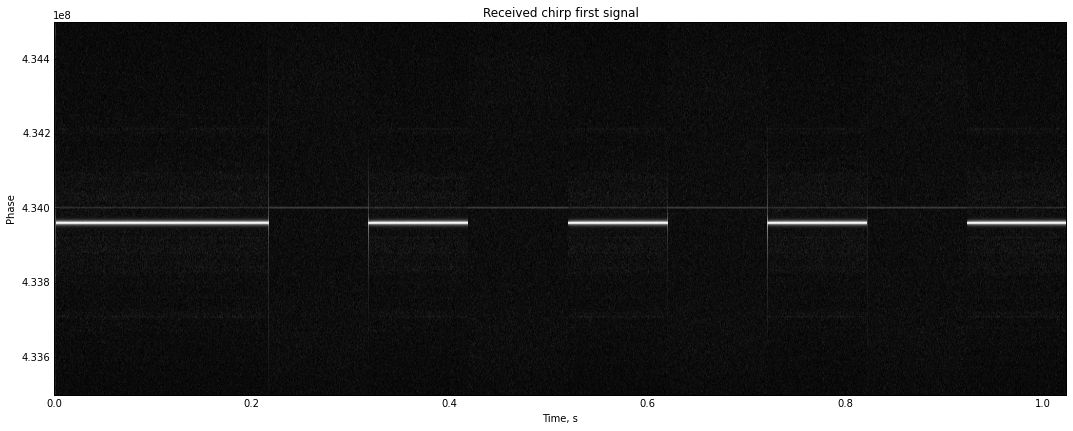

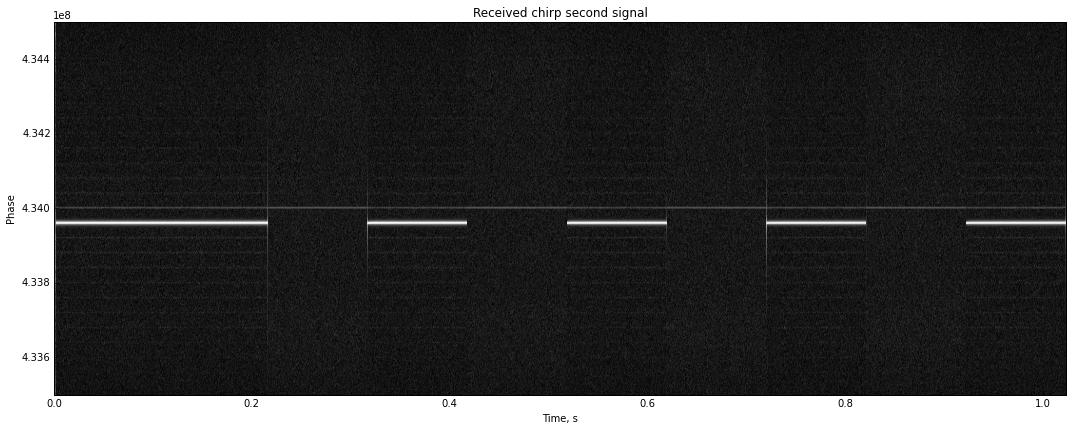

In [33]:
m = 512
fs = 1e6 #1e6 #3.2e6 #240000
fc = 434e6 #145.230e6 #145.530e6 #315e6 #144.25e6 #443.61e6

myspectrogram_hann_ovlp(y0, m, fs, fc, dbf = 60)
plt.title('Received chirp first signal')
myspectrogram_hann_ovlp(y1, m, fs, fc, dbf = 60)
plt.title('Received chirp second signal')
# myspectrogram_hann_ovlp(y2, m, fs, fc, dbf = 60)
# plt.title('Received chirp second signal')

470860
470860
470860


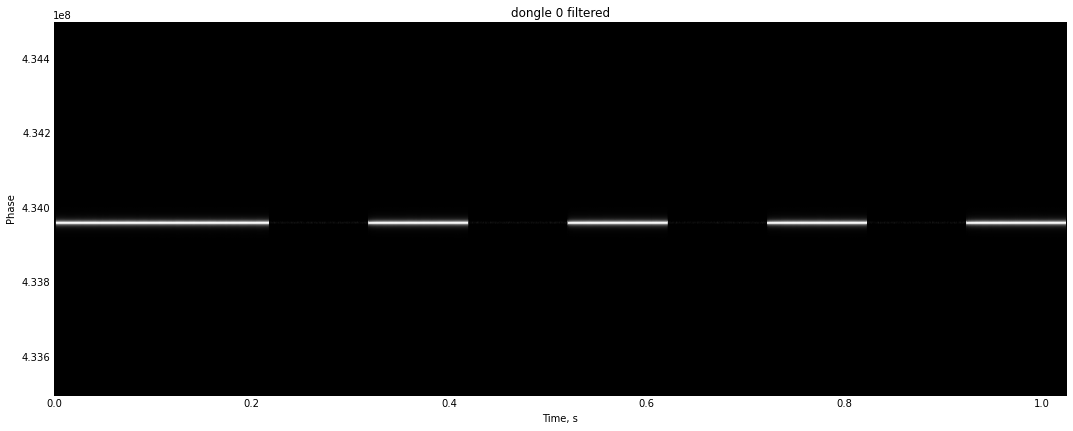

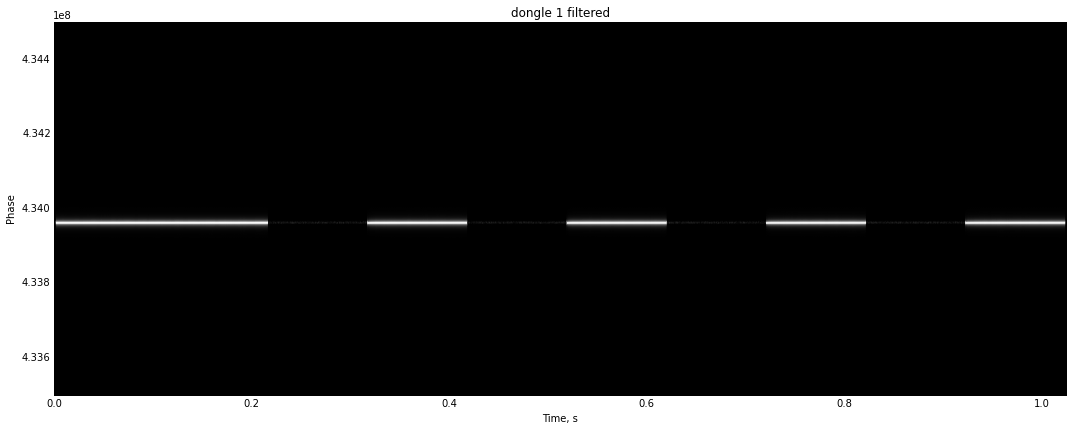

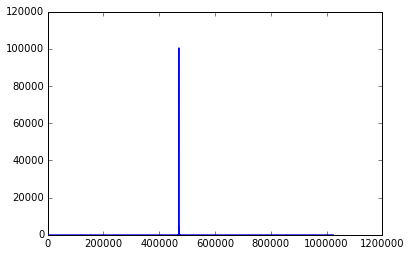

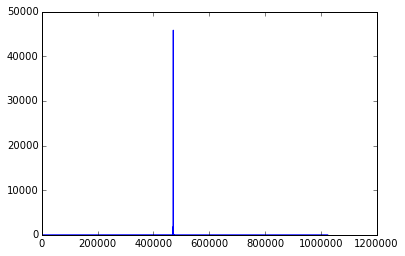

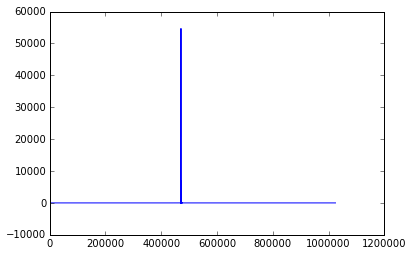

In [34]:
taps = 685
# taps = 700

mod_val = 0.04e6 #-0.3e6
h = sp.signal.firwin(taps, 1/fs)
t = np.arange(taps) * (1/fs)
mod = exp(-1j*2*pi*mod_val*t)
h = h*mod

filt_y0 = signal.fftconvolve(y0, h)
filt_y1 = signal.fftconvolve(y1, h)

myspectrogram_hann_ovlp(filt_y0, m, fs, fc,dbf = 63)
title('dongle 0 filtered')
myspectrogram_hann_ovlp(filt_y1, m, fs, fc,dbf = 63)
title('dongle 1 filtered')

freq0 = np.fft.fftshift(np.fft.fft(filt_y0)) 
freq1 = np.fft.fftshift(np.fft.fft(filt_y1)) 
figure()
plt.plot(abs(freq0))
figure()
plt.plot(abs(freq1))

print abs(freq0).tolist().index(max(abs(freq0)))
print abs(freq1).tolist().index(max(abs(freq1)))
print (abs(freq0)-abs(freq1)).tolist().index(max(abs(freq0)-abs(freq1)))

figure()
plt.plot((abs(freq0)-abs(freq1))) #[225000:275000]


In [35]:
# Calculating USB delay

# figure()
# plt.plot(filt_y0[4000:20000], label='antenna 0')
# plt.plot(filt_y1[4000:20000], label='antenna 1')
# plt.legend()

# figure()
# plt.plot(filt_y0, label='antenna 0')
# plt.plot(filt_y1, label='antenna 1')
# plt.legend()


filt_xcorr_abs = abs(signal.fftconvolve(filt_y0, np.conjugate(filt_y1)[::-1]))
filt_xcorr = signal.fftconvolve(filt_y0, np.conjugate(filt_y1)[::-1])
filt_trun_xcorr_abs = abs(signal.fftconvolve(filt_y0[int(len(h)/2)-1:-(int(len(h)/2))], (np.conjugate(filt_y1)[::-1])[int(len(h)/2)-1:-(int(len(h)/2))]))
filt_trun_xcorr = signal.fftconvolve(filt_y0[int(len(h)/2)-1:-(int(len(h)/2))], (np.conjugate(filt_y1)[::-1])[int(len(h)/2)-1:-(int(len(h)/2))])

# figure()
# plt.plot(filt_xcorr_abs)
# plt.plot(filt_xcorr)

# figure()
# plt.plot(filt_trun_xcorr_abs)
# plt.plot(filt_trun_xcorr)

orig_xcorr = signal.fftconvolve(y0, np.conjugate(y1)[::-1])
orig_xcorr_abs = abs(signal.fftconvolve(y0, np.conjugate(y1)[::-1]))

# figure()
# plt.plot(orig_xcorr)
# plt.plot(orig_xcorr_abs)

print np.argmax(filt_xcorr)-len(y0) + 1
print np.argmax(filt_xcorr_abs)-len(y0) + 1
print np.argmax(filt_trun_xcorr_abs)-len(y0) + 1
print np.argmax(filt_trun_xcorr)-len(y0) + 1
print np.argmax(orig_xcorr_abs)-len(y0) + 1
print np.argmax(orig_xcorr)-len(y0) + 1

delay = np.argmax(orig_xcorr_abs)-len(y0) + 1

1711
1691
1009
1029
1005
1027


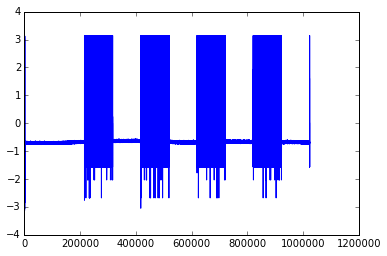

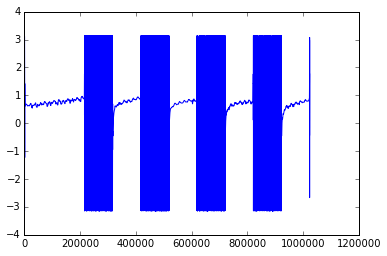

In [36]:
# 1031 1044
phase_diff = np.angle(y0[delay:] * np.conjugate(y1[:-delay]))
figure()
plt.plot(phase_diff)

phase_diff = np.angle(filt_y0[1691:] * np.conjugate(filt_y1[:-1691]))
figure()
plt.plot(phase_diff)


In [37]:
phase_sweep = np.arange(0,1,1/20) * 2 * pi
all_summed = []
for phase in phase_sweep:
    summed = y0 + phase * y1
    all_summed.append(max(abs(summed)))
    
ind = np.argmax(np.array(all_summed))

print all_summed
print np.argmax(all_summed)
print phase_sweep[ind]

[0.56024929915268651, 0.61321215698899267, 0.69375469267569845, 0.77429729213838305, 0.85483993735022246, 0.93538261649330001, 1.015925321497398, 1.0964680466635366, 1.1770107878526563, 1.2575535419860779, 1.3380963067263694, 1.4186390802669262, 1.4991818611893786, 1.5797246483646219, 1.6602674408826512, 1.7408102380018757, 1.8213530391118813, 1.9018958437056552, 1.9824386513585799, 2.0629814617123503]
19
5.96902604182


In [40]:
phase_sweep = np.arange(-0.5,0.5,1/20) * 2 * pi
all_summed = []
for phase in phase_sweep:
    summed = filt_y0 + phase * filt_y1
#     all_summed.append(max(abs(summed)))
    all_summed.append(np.dot(summed, summed))
    
ind = np.argmax(np.array(all_summed))

# print all_summed
print np.argmax(all_summed)
print phase_sweep[ind]

19
2.82743338823


#Chirp Shit

1


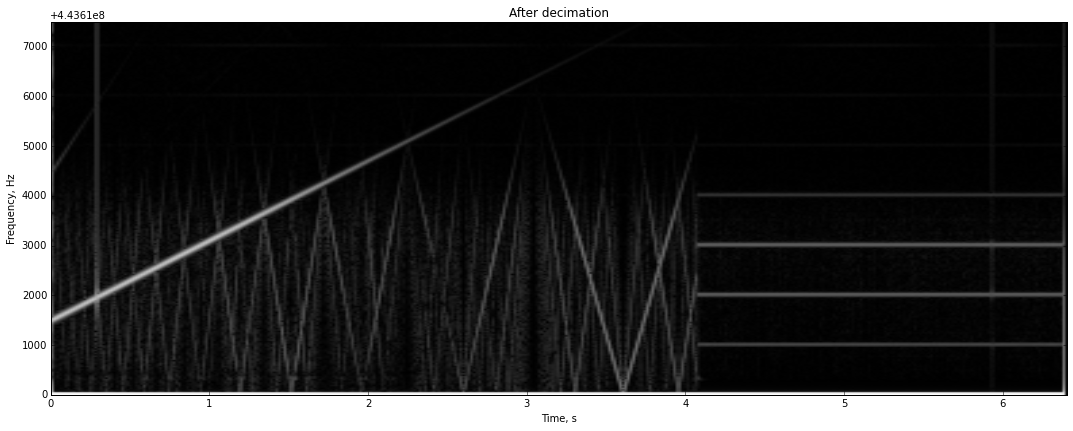

In [23]:
# Your code here:
sample_rate = fs

h = sp.signal.firwin(128,25000.0,nyq=sample_rate/2)
filt_y0 = signal.fftconvolve(y0, h)

x0 = filt_y0[:len(filt_y0)-1] * np.ma.conjugate(filt_y0[1:])
x0 = np.angle(x0)

h = sp.signal.firwin(128,8000.0,nyq=sample_rate/2)
filt_x0 = signal.fftconvolve(x0, h)

down_x0 = np.zeros(len(filt_x0)/16 + 1)
ind = 0
for i in range(0,len(filt_x0),16):
    down_x0[ind] = filt_x0[i]
    ind += 1

myspectrogram_hann_ovlp(down_x0, m, sample_rate / 16, fc,dbf = 63)
title('After decimation')


1


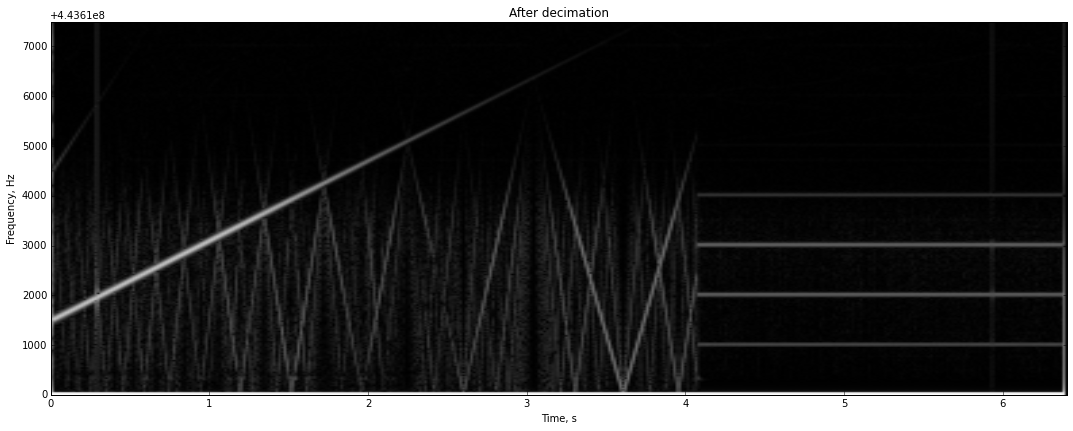

In [24]:
# SECOND DONGLE

h = sp.signal.firwin(128,25000.0,nyq=sample_rate/2)
filt_y1 = signal.fftconvolve(y1, h)

x1 = filt_y1[:len(filt_y1)-1] * np.ma.conjugate(filt_y1[1:])
x1 = np.angle(x1)

h = sp.signal.firwin(128,8000.0,nyq=sample_rate/2)
filt_x1 = signal.fftconvolve(x1, h)

down_x1 = np.zeros(len(filt_x1)/16 + 1)
ind = 0
for i in range(0,len(filt_x1),16):
    down_x1[ind] = filt_x1[i]
    ind += 1

myspectrogram_hann_ovlp(down_x1, m, sample_rate / 16, fc,dbf = 63)
title('After decimation')

## Third Dongle

# h = sp.signal.firwin(128,25000.0,nyq=sample_rate/2)
# filt_y2 = signal.fftconvolve(y2, h)

# x2 = filt_y2[:len(filt_y2)-1] * np.ma.conjugate(filt_y2[1:])
# x2 = np.angle(x2)

# h = sp.signal.firwin(128,8000.0,nyq=sample_rate/2)
# filt_x2 = signal.fftconvolve(x2, h)

# down_x2 = np.zeros(len(filt_x2)/16 + 1)
# ind = 0
# for i in range(0,len(filt_x2),16):
#     down_x2[ind] = filt_x2[i]
#     ind += 1

# myspectrogram_hann_ovlp(down_x2, m, sample_rate / 16, fc,dbf = 63)
# title('After decimation')

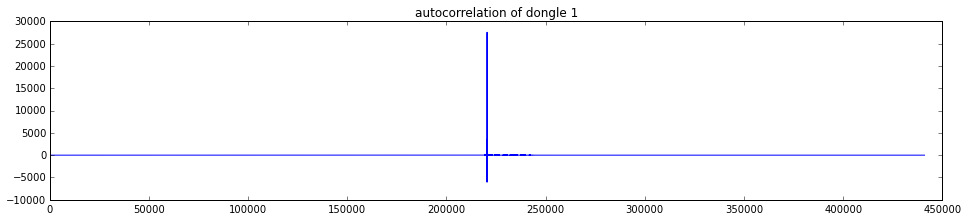

In [23]:
# expected autocorrelation
chirp_acorr = signal.fftconvolve(chirp,chirp[::-1])

width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot((chirp_acorr))
plt.title( 'autocorrelation of transmitted chirp' )

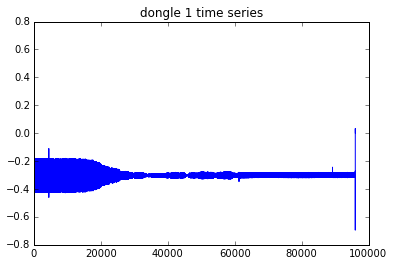

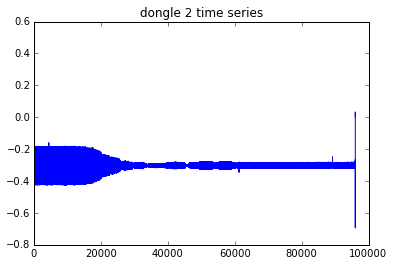

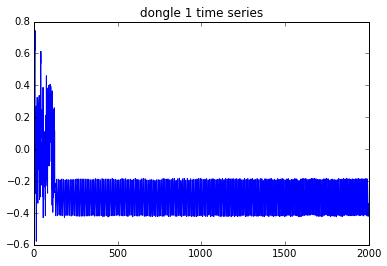

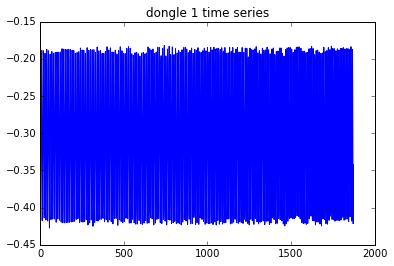

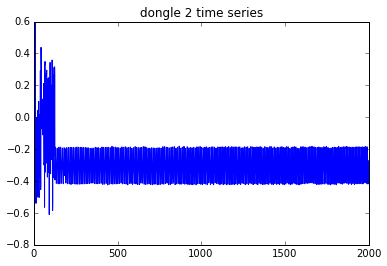

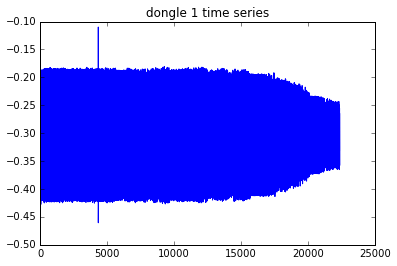

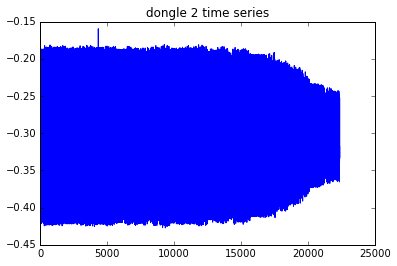

In [18]:
temp1= down_x0
temp2 = down_x1
cutoff = sample_rate / 16 * 1.5

plt.plot(down_x0) #[:2000]
plt.title('dongle 1 time series')
figure()
plt.plot(down_x1) #[:2000]
plt.title('dongle 2 time series')
figure()
plt.plot(down_x0[:2000]) #[:2000] int(len(h)/2)-1
plt.title('dongle 1 time series')
figure()
plt.plot(down_x0[int(len(h))-1:2000]) #[:2000] 
plt.title('dongle 1 time series')
figure()
plt.plot(down_x1[:2000]) #[:2000] 
plt.title('dongle 2 time series')
figure()
plt.plot(down_x0[int(len(h))-1:cutoff]) #[:2000] 
plt.title('dongle 1 time series')
figure()
plt.plot(down_x1[int(len(h))-1:cutoff]) #[:2000] 
plt.title('dongle 2 time series')



In [19]:
down_x0 = temp1
down_x1 = temp2

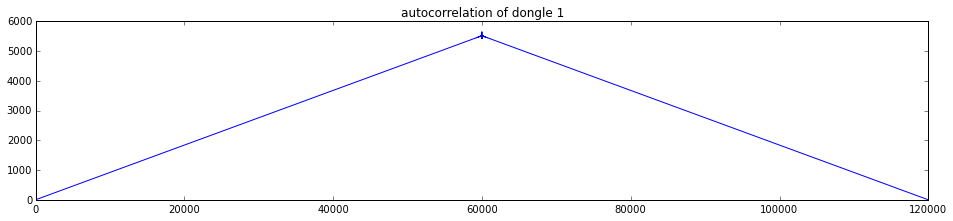

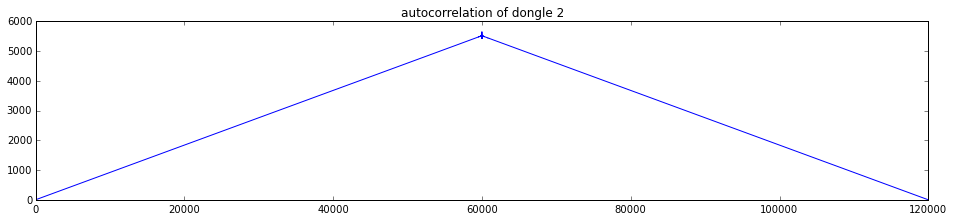

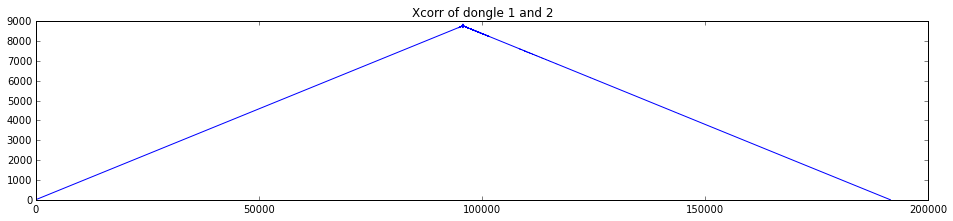

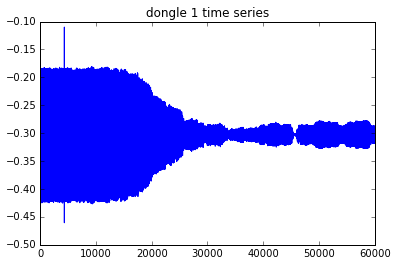

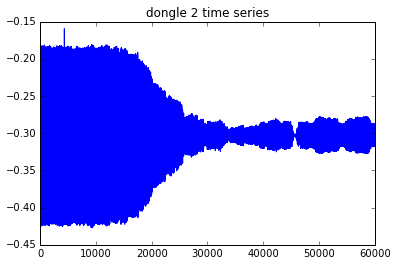

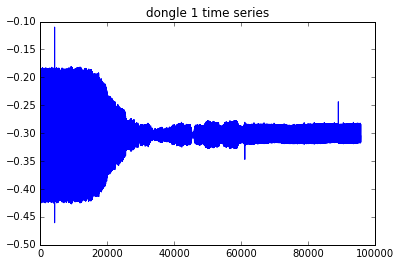

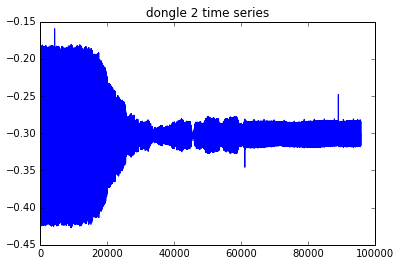

In [20]:
cutoff = sample_rate / 16 * 4
down_x0 = down_x0[len(h):-(len(h))]
down_x1 = down_x1[len(h):-(len(h))]

#Dongle 1 autocorr
dong1_autocorr = signal.fftconvolve(down_x0[:cutoff],down_x0[cutoff::-1]) #[200:]

width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot((dong1_autocorr)) #[1000:len(dong1_autocorr)-1000]
plt.title( 'autocorrelation of dongle 1' )

#Dongle 2 autocorr
dong2_autocorr = signal.fftconvolve(down_x1[:cutoff],down_x1[cutoff::-1]) #[200:]

width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot((dong2_autocorr)) #[1000:len(dong2_autocorr)-1000]
plt.title( 'autocorrelation of dongle 2' )

# Xcorr dongles 1 and 2
dong12_xcorr = signal.fftconvolve(down_x0[:],down_x1[::-1])

width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot((dong12_xcorr))
plt.title( 'Xcorr of dongle 1 and 2' )

figure()
plt.plot(down_x0[:cutoff])
plt.title('dongle 1 time series')
figure()
plt.plot(down_x1[:cutoff])
plt.title('dongle 2 time series')
figure()
plt.plot(down_x0)
plt.title('dongle 1 time series')
figure()
plt.plot(down_x1)
plt.title('dongle 2 time series')


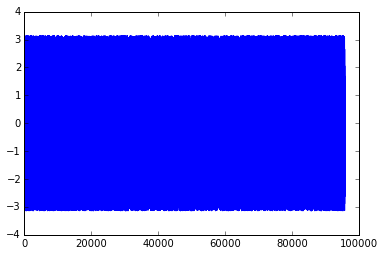

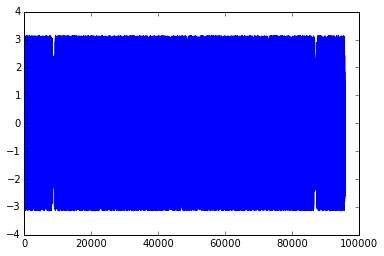

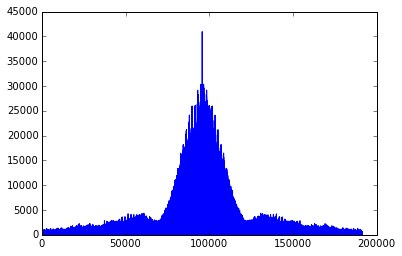

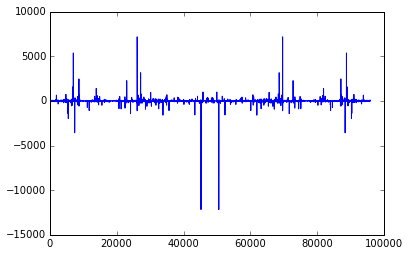

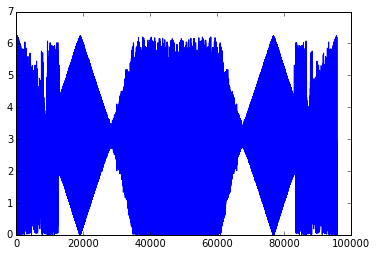

In [16]:
figure()
plt.plot(np.angle(np.fft.fft(down_x0)))
figure()
plt.plot(np.angle(np.fft.fft(down_x1)))


ph0 = (np.angle(np.fft.fft(down_x0)))
ph1 = (np.angle(np.fft.fft(down_x1)))

figure()
plt.plot(abs(signal.fftconvolve(ph0, ph1[::-1])))

figure()
plt.plot(ph0/ph1)

figure()
plt.plot(abs(ph0-ph1))

([0.0, 4.096],
 [314500000.0, 315500000.0],
 array([[-0.11159261 +1.47222375e-01j,  0.10463499 +4.59508453e-01j,
          0.05163653 +1.67391063e-01j, ..., -0.32646718 +1.94830948e-01j,
         -0.19689659 -7.88531350e-02j,  0.04824411 -2.02649204e-01j],
        [-0.02805130 -3.90491917e-02j, -0.16021937 -2.87036049e-01j,
         -0.03496531 -3.17716115e-02j, ...,  0.10666752 -2.06633959e-01j,
          0.22724825 +1.78318736e-01j, -0.15539940 +1.05678550e-01j],
        [ 0.07348616 -2.50096821e-02j,  0.22419749 +4.09565960e-02j,
          0.10229373 -2.29895890e-04j, ..., -0.04439206 +1.28568159e-01j,
          0.10804145 -1.37091839e-01j,  0.06627226 -6.82050621e-03j],
        ..., 
        [-0.14008607 -8.95988552e-04j,  0.11874882 +3.29703311e-02j,
         -0.06883479 +1.34908480e-01j, ...,  0.21783580 +5.29659880e-01j,
         -0.33236787 -4.02218323e-02j,  0.08564269 +8.09955348e-02j],
        [ 0.06860992 -6.12907290e-02j,  0.05329328 +4.48424222e-05j,
          0.07303291 

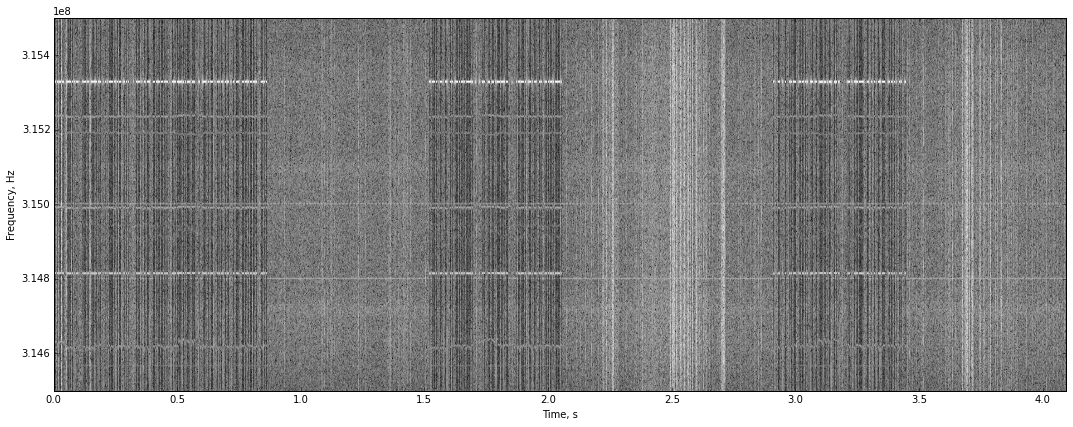

In [17]:
m = 512
fs = sample_rate
fc = center_freq

myspectrogram_hann_ovlp(y0, m, fs, fc, dbf = 60)

# myspectrogram_hann_ovlp(y1, m, fs, fc,dbf = 60)

# myspectrogram_hann_ovlp(y2, m, fs, fc,dbf = 60)

In [ ]:
#UNUSED
sample_rate = 1e6 #240000
center_freq = 315e6 #(car keys) #96.3e6 (alice FM radio) #97.3 #443.610e6 #433.92e6 (car keys)
gain = 36
t_total = 4             # 8
N_samples = 1024000*t_total   # 256000

sdr0 = RtlSdr(device_index=0)
sdr0.sample_rate = sample_rate     # sampling rate  1000000
sdr0.center_freq = center_freq   # 162MhZ center frequency 162e6
sdr0.gain = gain 
y0 = sdr0.read_samples(N_samples)
sdr0.close()


# analytic correlation 
down_x0_a = signal.hilbert(down_x0)
down_x1_a = signal.hilbert(down_x1)
dong12_xcorr_a = signal.fftconvolve(down_x0_a,down_x1_a[::-1])

width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot((dong12_xcorr_a))
plt.title( 'Xcorr of dongle 1 and 2 analytics' )

figure()
plt.plot(down_x0_a[:1000])
plt.title('dongle 1 time series -- analytic')
figure()
plt.plot(down_x1_a[:1000])
plt.title('dongle 1 time series -- analytic')